In [44]:
import biograph.protein
import numpy as np
import biograph.graph_models as graph_models
from biograph.downloader import PdbDownloader, ConsurfDBDownloader
from biograph.protein import Protein
from biograph.structure import Perseus
from biograph.groupfolds import CDHitGroup
import networkx as nx

In [239]:
import requests
import json
pdbid="5dn6"
sifts = requests.get(f"https://www.ebi.ac.uk/pdbe/api/mappings/uniprot/{pdbid}")
uniprot = json.JSONDecoder().decode(sifts.content.decode())[pdbid]["UniProt"]

In [246]:
set([mapping["entity_id"] for dic in uniprot.values() for mapping in dic["mappings"]])

{4, 5, 6, 7, 8, 9, 12, 14}

In [250]:
len(set([mapping["chain_id"] for dic in uniprot.values() for mapping in dic["mappings"]]))

23

In [261]:
a = set([mapping["chain_id"] for dic in uniprot.values() for mapping in dic["mappings"]])
a.update(set([mapping["struct_asym_id"] for dic in uniprot.values() for mapping in dic["mappings"]]))
len(a)


27

In [262]:
uniprot

{'A1B8P0': {'identifier': 'ATPB_PARDP',
  'name': 'ATPB_PARDP',
  'mappings': [{'entity_id': 5,
    'end': {'author_residue_number': None,
     'author_insertion_code': '',
     'residue_number': 474},
    'chain_id': 'D',
    'start': {'author_residue_number': None,
     'author_insertion_code': '',
     'residue_number': 1},
    'unp_end': 474,
    'unp_start': 1,
    'struct_asym_id': 'G'},
   {'entity_id': 5,
    'end': {'author_residue_number': None,
     'author_insertion_code': '',
     'residue_number': 474},
    'chain_id': 'E',
    'start': {'author_residue_number': None,
     'author_insertion_code': '',
     'residue_number': 1},
    'unp_end': 474,
    'unp_start': 1,
    'struct_asym_id': 'H'},
   {'entity_id': 5,
    'end': {'author_residue_number': None,
     'author_insertion_code': '',
     'residue_number': 474},
    'chain_id': 'F',
    'start': {'author_residue_number': None,
     'author_insertion_code': '',
     'residue_number': 1},
    'unp_end': 474,
    'unp_

In [212]:
protein = biograph.protein.Protein("../data/5DN6.pdb")

/usr/local/lib/python3.6/dist-packages/biograph/protein.py:86: UserWarning: suppress_bio_warnings=True, ignoring Bio's warnings.
  warnings.warn("suppress_bio_warnings=True, ignoring Bio's warnings.")


In [252]:
len(protein.df.chain.unique())

29

In [213]:
print(protein.df.shape)
#protein.df = protein.df.loc[protein.df.chain=="A"] #manual uniprot id filter
protein.df.shape

(31563, 13)


(31563, 13)

In [214]:
print(protein.df.shape)
protein.df = protein.df[~protein.df.coord.isnull()]
print(protein.df.shape)
ATP_coords = protein.df[protein.df.resname == "ATP"].coord.to_list()
len(ATP_coords)

(31563, 13)
(31563, 13)


124

In [215]:
protein.df["distance"] = protein.df.coord.apply(
        lambda atom: min(map(lambda atp_atom: np.linalg.norm(atom-atp_atom), ATP_coords))
    )

In [216]:
protein.df["distance"] = protein.df.coord.apply(
    lambda atom: min(map(lambda atp_atom: np.linalg.norm(atom-atp_atom), ATP_coords))
)
protein.discard_ligands()
print(protein.df.shape)
protein.df = protein.df.loc[
            protein.df.apply(lambda row: row["full_id"][4][0] == "CA", axis=1),:].reset_index(drop=True)
print(protein.df.shape)

(31407, 14)
(4686, 14)


In [217]:
ATP_coords = protein.df[protein.df.resname == "ATP"].coord.to_list()
len(ATP_coords)

0

In [218]:
structure = protein.generate_structure(lambda row: row["full_id"][4][0] == "CA")

perseus = Perseus()
perseus.execute_persistent_hom(protein)

structure_model = graph_models.StructureGraphGenerator()
protein.generate_graph(structure_model,
    {"step": structure.persistent_hom_params["b3_step"]})
depths, _ = structure.calculate_depth(protein.graph)
for node_idx, depth in depths.items():
    protein.graph.nodes[node_idx]["depth"] = depth

# Identify chain uniquely (useful later to match with CDHit)
protein.df["chain"] = protein.pdb.id + "_" + protein.df.chain
# Rest of features
structure_model.add_features(protein.df, columns = [
    "bfactor", "score", "color",
    "color_confidence_interval_high", "color_confidence_interval_low",
    "score_confidence_interval_high", "score_confidence_interval_low",
    "resname", "coord", "distance",
    "chain"
])

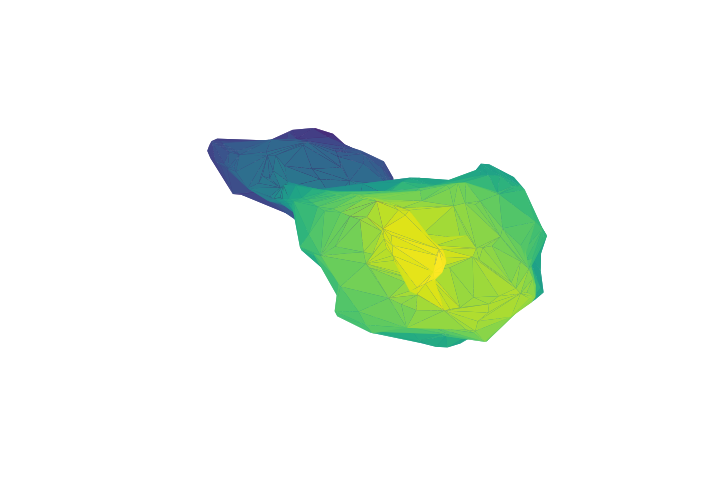

In [219]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
triangles = structure.get_simplices_by_step(structure.persistent_hom_params["b3_step"])
ax = plt.axes(projection='3d')
ax.view_init(-270, -90)
ax.plot_trisurf(structure.points[:, 0]-100, structure.points[:, 1]+400,
                structure.points[:, 2], triangles=triangles, cmap="viridis")
ax._axis3don = False

In [220]:
import matplotlib.colors as colors
graph_cmap = colors.ListedColormap(["#1e75e8", "#e81e75"])
def draw_chain_colored(graph, cmap=graph_cmap):
    graph = graph.copy()
    group_color = {}
    colors = []
    sizes = []

    for idx in graph.nodes():
        group = graph.nodes[idx]["full_id"][2]
        if group  not in group_color:
            group_color[group] = len(group_color)

        dist = graph.nodes[idx]["distance"]
        
        if dist < 6:
            #size = 300
            colors.append(1)
        else:
            colors.append(group_color[group])
        size = 50
        sizes.append(size)
    ax = plt.subplot()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    nx.draw_networkx(
        graph, 
        pos = {idx:graph.nodes[idx]["coord"][0:2] for idx in graph.nodes},
        node_color = colors,
        node_size=sizes, with_labels=False, cmap=cmap, edge_color="#6c8cb5")

4686 35257


/home/joaquintz/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


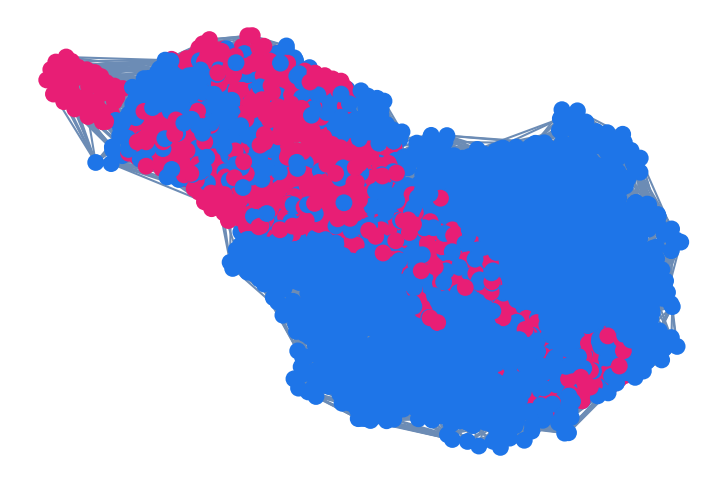

In [221]:
print(protein.graph.number_of_nodes(),protein.graph.number_of_edges())
draw_chain_colored(protein.graph)

In [63]:
def remove_interior(graph):
    edges_to_remove = set()
    nodes_to_remove = set()
    for node_idx, adj_dict in graph.adjacency():
        neighbors_not_in_surf = [k for k,v in adj_dict.items() if not v["in_surf"]]
        edges_to_remove.update([
            (node_idx, neighbor)  if node_idx < neighbor else (neighbor, node_idx) 
            for neighbor in neighbors_not_in_surf])
        if len(adj_dict) == len(neighbors_not_in_surf):
            nodes_to_remove.add(node_idx)
    edges_before = graph.number_of_edges()
    nodes_before = graph.number_of_nodes()
    for edge in edges_to_remove:
        graph.remove_edge(*edge)
    for idx in nodes_to_remove:
        graph.remove_node(idx)
    return graph
#edges_before, graph.number_of_edges(), nodes_before, graph.number_of_nodes()

4686 35257
550 1660


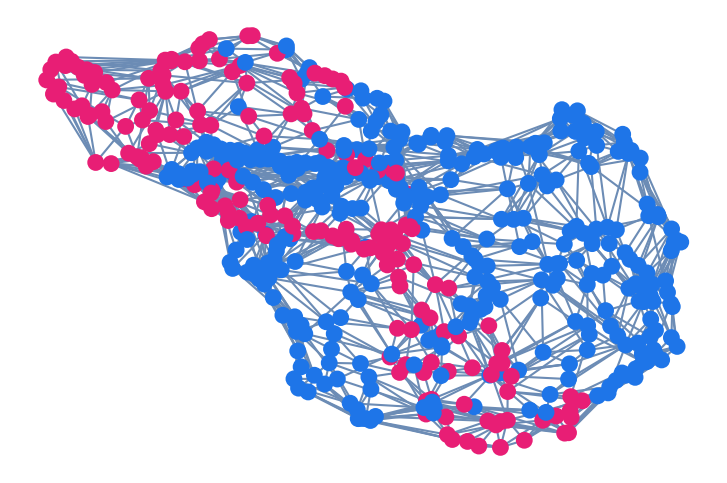

In [222]:
interior_graph = remove_interior(protein.graph.copy())
print(protein.graph.number_of_nodes(),protein.graph.number_of_edges())
print(interior_graph.number_of_nodes(),interior_graph.number_of_edges())
draw_chain_colored(interior_graph)

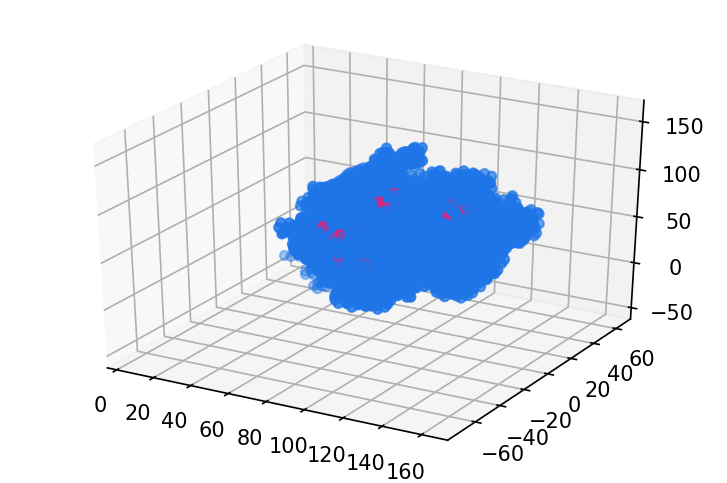

In [223]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
graph = protein.graph
#graph = interior_graph
X = np.array([graph.nodes[idx]["coord"] for idx in graph.nodes])
ax.scatter(
    *X.T, 
    c=[int(graph.nodes[idx]["distance"]<=6.0) for idx in graph.nodes], 
    cmap=graph_cmap)

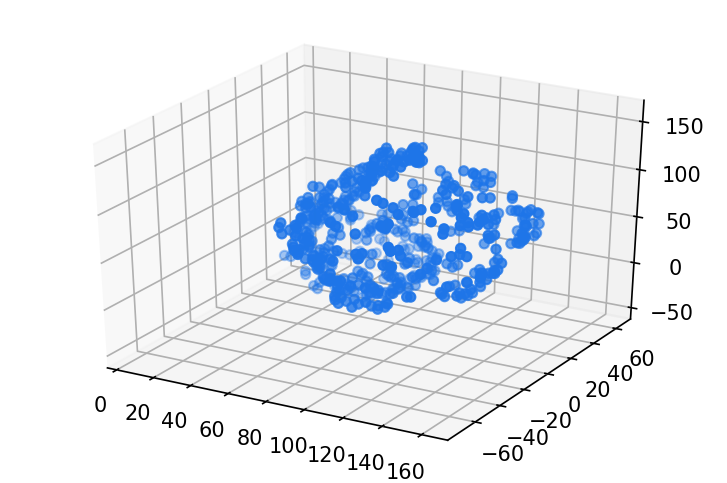

In [224]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
graph = interior_graph
X = np.array([graph.nodes[idx]["coord"] for idx in graph.nodes])
ax.scatter(
    *X.T, 
    c=[int(graph.nodes[idx]["distance"]<=6.0) for idx in graph.nodes], 
    cmap=graph_cmap)